# invert synthetic data using different parameterizations

## Intro : imports, prompt help

In [1]:
import sys, glob, os
from srfpython import *
try:
    check_herrmann_codes()
except Exception:
    recompile_src90(yes=False)
    check_herrmann_codes()

In [2]:
rm -rf _HerrMet* *.surf96 *.mod96

In [3]:
ls ./*

./tutorial1.ipynb


In [4]:
%run -i ../../srfpython/bin/HerrMet -h

HerrMet V6.0
# ------- main options (s=string, i=int, f=float)
-version, -v          version number, quit
-help, -h   [s...]    help, provide plugin names for details, quit
-example, -ex s [s..] example usage, provide plugin names for details, quit
-w           i        number of virtual workers, default None
-taskset     s        affinity, e.g. "0-3", default None
-lowprio              run processes with low priority if mentioned
-verbose     i        reduce verbosity, 0/1, default 1
# ------- plugins, use --help plugin [plugin ...] for details
--target     set the target data, create temporary directories (rootnames)
--param      create a template parameterization file
--send       send the parameterization to the temporary directories
--run        invert dispersion data using the Markov Chain Monte Carlo method
--manage     summarize run file content, manage run results
--neldermead NOT READY, optimize best solutions from run using the nelder mead algorithm
--extract    compute and 

## I/ Create synthetic data

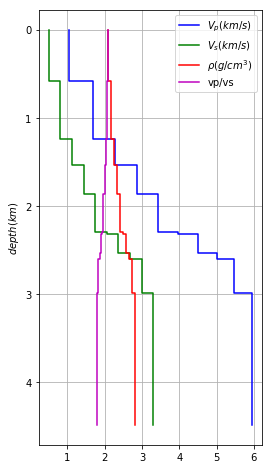

In [5]:
# -----------------
# generate a random depth model
# -----------------
ztop = np.unique(np.sort(np.random.rand(10))) * 3.
ztop[0] = 0.
vs   = np.linspace(.5, 3.3, len(ztop))
pr   = np.linspace(2.1, 1.8, len(ztop))
rh   = np.linspace(2.1, 2.8, len(ztop))
vp = np.array(pr) * np.array(vs)

dm = depthmodel_from_arrays(ztop, vp, vs, rh)
plt.figure(figsize = (4,8))
dm.show(gca())
dm.pr().show(gca(), color = "m", label="vp/vs")
gca().grid(True)
plt.legend()

dm.write96('dmtuto.mod96')

dmtuto.mod96 => dmtuto.surf96
dmtuto.surf96
    Claw wave=L mode=0 type=C flag=T extrapmode=0 N=12
    Claw wave=L mode=1 type=C flag=T extrapmode=1 N=9
    Ulaw wave=L mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=L mode=1 type=U flag=T extrapmode=1 N=9
    Claw wave=R mode=0 type=C flag=T extrapmode=0 N=12
    Claw wave=R mode=1 type=C flag=T extrapmode=1 N=11
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=R mode=1 type=U flag=T extrapmode=1 N=11


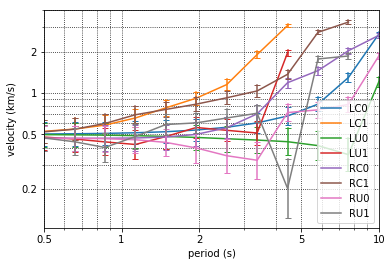

In [6]:
# -----------------
# compute the corresponding dispersion curves
# -----------------

os.system('rm -f dmtuto.surf96')
%run -i ../../srfpython/bin/m96 \
    --disp dmtuto.mod96 \
        -RU0 .1  2. 12 "log" \
        -LU0 .1  2. 12 "log" \
        -RU1 .1  2. 12 "log" \
        -LU1 .1  2. 12 "log" \
        -RC0 .1  2. 12 "log" \
        -LC0 .1  2. 12 "log" \
        -RC1 .1  2. 12 "log" \
        -LC1 .1  2. 12 "log" \
        -save dmtuto.surf96
        
%run -i ../../srfpython/bin/s96 \
    --show dmtuto.surf96 \
        -inline        


## II/ Invert data with 3 different parameterizations (2, 3, or 4 layers)

In [7]:
# -----------------
# clean up, prepare files for 3 inversions
# dmtuto.mod96 = synthetic model (the expected solution)
# dmtuto.surf96 = synthetic data (the data to invert)
# we generate 3 copies of dmtuto.surf96, to be used as targets by HerrMet
# -----------------
os.system('''
rm -rf _HerrMet*
mv dmtuto.surf96  2layers.surf96 #target 1
cp 2layers.surf96 3layers.surf96 #target 2
cp 2layers.surf96 4layers.surf96 #target 3
''')
for _ in glob.glob('./*'):
    print _, 


./dmtuto.mod96 ./2layers.surf96 ./3layers.surf96 ./4layers.surf96 ./tutorial1.ipynb


In [8]:
# -----------------
# set target data, create temporary directories (1 per target file)
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --target ?layers.surf96 \
        -lunc .3 \
        -ot

writing _HerrMet_2layers/_HerrMet.target
writing _HerrMet_3layers/_HerrMet.target
writing _HerrMet_4layers/_HerrMet.target
please keep only datapoints to invert in */_HerrMet.target
use option --display to see the target data


In [ ]:
#ls -lrth ./*

_HerrMet_2layers/_HerrMet.target
    Claw wave=L mode=0 type=C flag=T extrapmode=0 N=12
    Claw wave=L mode=1 type=C flag=T extrapmode=1 N=9
    Ulaw wave=L mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=L mode=1 type=U flag=T extrapmode=1 N=9
    Claw wave=R mode=0 type=C flag=T extrapmode=0 N=12
    Claw wave=R mode=1 type=C flag=T extrapmode=1 N=11
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=R mode=1 type=U flag=T extrapmode=1 N=11


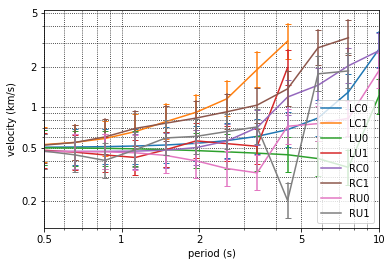

In [9]:
# show target (qc)
%run -i ../../srfpython/bin/s96 \
    --show _HerrMet_2layers/_HerrMet.target \
        -inline

# Parameterization

In [10]:
# -----------------
# set parameterization template, with two layers (in ./_HerrMet.param)
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --param 2 3. \
        -t mZVSPRRH \
        -growing \
        -op \
    --send   
    
# the template file is no longer needed, 
# the next cells reproduce the file content in _HerrMet_*/_HerrMet.param    
os.system('rm -f ./_HerrMet.param') 

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 2
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -3.000000        -0.001000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       PR0         1.700000         2.150000
       PR1         1.700000         2.150000
       RH0         1.800000         3.000000
       RH1         1.800000         3.000000

please customize _HerrMet.param, do not change line orders and metadata
use option --display to see the depth boundaries
cp ./_HerrMet.param _HerrMet_2layers/
cp ./_HerrMet.param _HerrMet_3layers/
cp ./_HerrMet.param _HerrMet_4layers/


0

In [11]:
# -----------------
# customize parameterization manually : 2 layers case
# -----------------
with open('_HerrMet_2layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 2
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -3.000000        -0.001000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       PR0         1.79             2.12
       PR1         1.79             2.12
       RH0         2.1              2.9
       RH1         2.1              2.9""")

In [12]:
# -----------------
# customize parameterization manually : 3 layers case
# -----------------
with open('_HerrMet_3layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 3
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -2.              -0.001000
       -Z3        -3.000000        -1.
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       PR0         1.79             2.12
       PR1         1.79             2.12
       PR2         1.79             2.12       
       RH0         2.1              2.9
       RH1         2.1              2.9
       RH2         2.1              2.9""")
#%run -i ../../srfpython/bin/HerrMet \
#    --display _HerrMet_3layers \
#        -m96 dmtuto.mod96 \
#        -inline

In [13]:
# -----------------
# customize parameterization manually : 4 layers case
# -----------------
with open('_HerrMet_4layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -1.000000        -0.001000
       -Z2        -2.000000        -0.500000
       -Z3        -3.000000        -1.000000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       VS3         0.100000         3.500000
       PR0         1.79             2.12       
       PR1         1.79             2.12       
       PR2         1.79             2.12       
       PR3         1.79             2.12          
       RH0         2.1              2.9
       RH1         2.1              2.9
       RH2         2.1              2.9
       RH3         2.1              2.9""")

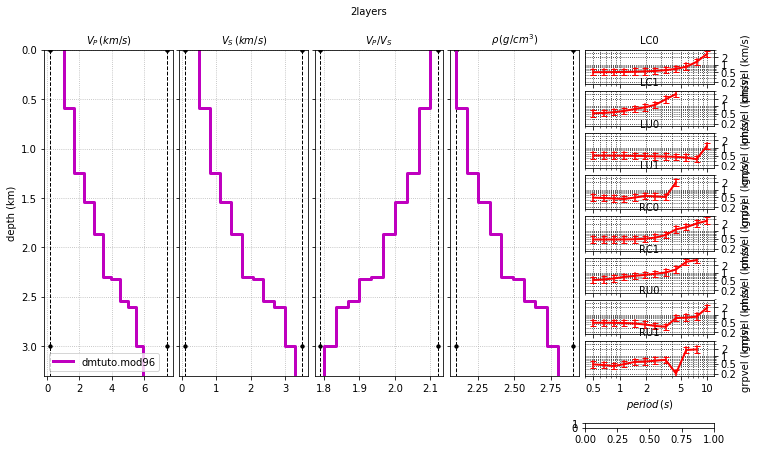

In [14]:
# check parameterizations for all 3 parameterizations
#%run -i ../../srfpython/bin/HerrMet \
#    --display \
#        -m96 dmtuto.mod96 \
#        -inline

# check parameterizations for 2 layers only
%run -i ../../srfpython/bin/HerrMet \
    --display _HerrMet_2layers \
        -m96 dmtuto.mod96 \
        -inline

In [15]:
# -----------------
# run all inversions in restart mode, 
# the inversion is parallelized over the markov chains 
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -w 8 \
    -taskset "0-3" \
    -verbose 0 \
    --run \
        -nchain 16 \
        -nkeep 200 
print "DONE"

   2layers chain    5  DONE kept  200/ 1142 fail   28 AK 0.17 MP 0.06 AS  41.32/s BST -109.296013
   2layers chain    4  DONE kept  200/ 1148 fail   26 AK 0.17 MP 0.04 AS  41.24/s BST -105.465949
   2layers chain    0  DONE kept  200/ 1163 fail   21 AK 0.17 MP 0.05 AS  40.61/s BST -143.185276
   2layers chain    3  DONE kept  200/ 1183 fail   33 AK 0.17 MP 0.04 AS  41.31/s BST -104.046856
   2layers chain    7  DONE kept  200/ 1158 fail   31 AK 0.17 MP 0.04 AS  41.27/s BST -104.490892
   2layers chain    6  DONE kept  200/ 1190 fail   49 AK 0.17 MP 0.04 AS  41.39/s BST -108.673823
   2layers chain    2  DONE kept  200/ 1233 fail   49 AK 0.16 MP 0.03 AS  40.69/s BST -104.467635
   2layers chain    1  DONE kept  200/ 1339 fail   24 AK 0.15 MP 0.01 AS  40.25/s BST -152.727011
   2layers chain   10  DONE kept  200/  913 fail   36 AK 0.22 MP 0.33 AS  40.77/s BST -138.853225
   2layers chain   12  DONE kept  200/  961 fail   27 AK 0.21 MP 0.23 AS  41.19/s BST -111.348442
   2layers chain   1

In [16]:
# -----------------
# manage results
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -verbose 0 \
    --manage 

_HerrMet_2layers :     16 chains,   3216 models, worst -673652.820602, best -103.804622, filesize 6M
_HerrMet_3layers :     16 chains,   3214 models, worst -1405161.678987, best  -2.829901, filesize 6M
_HerrMet_4layers :     16 chains,   3210 models, worst -2265144.092082, best  -1.974646, filesize 6M


_HerrMet_4layers :     16 chains,   3210 models, worst -2265144.092082, best  -1.974646, filesize 6M


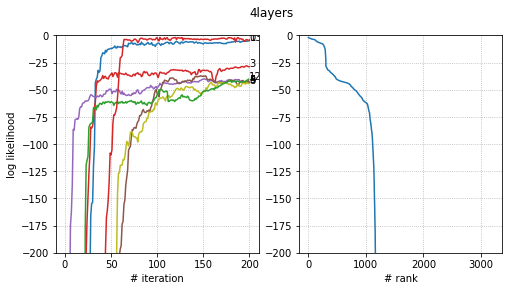

In [2]:
%run -i ../../srfpython/bin/HerrMet \
    -verbose 0 \
    --manage _HerrMet_4layers  \
        -plot -200. \
        -inline

plot : best, limit 200, llkmin 0.000000, step 1 retrieved 200 models in 0.933205s 
pdf : last, limit 0, llkmin 0.000000, step 1 retrieved 3216 models in 1.843368s 
Stacker Worker-0008 stacked    351 jobs in 0.161500s
Stacker Worker-0005 stacked    380 jobs in 0.169623s
Stacker Worker-0002 stacked    446 jobs in 0.195448s
Stacker Worker-0004 stacked    427 jobs in 0.187244s
Stacker Worker-0001 stacked    467 jobs in 0.208230s
Stacker Worker-0006 stacked    380 jobs in 0.167654s
Stacker Worker-0003 stacked    405 jobs in 0.181318s
Stacker Worker-0007 stacked    360 jobs in 0.168743s


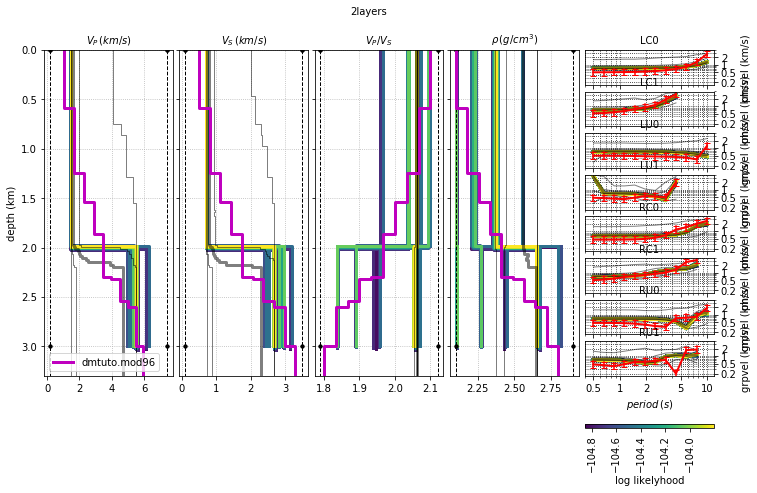

plot : best, limit 200, llkmin 0.000000, step 1 retrieved 200 models in 0.960173s 
pdf : last, limit 0, llkmin 0.000000, step 1 retrieved 3214 models in 1.783196s 
Stacker Worker-0007 stacked    380 jobs in 0.258886s
Stacker Worker-0006 stacked    403 jobs in 0.251881s
Stacker Worker-0002 stacked    406 jobs in 0.266330s
Stacker Worker-0008 stacked    422 jobs in 0.276755s
Stacker Worker-0004 stacked    394 jobs in 0.268974s
Stacker Worker-0005 stacked    371 jobs in 0.245928s
Stacker Worker-0003 stacked    398 jobs in 0.270069s
Stacker Worker-0001 stacked    440 jobs in 0.273259s


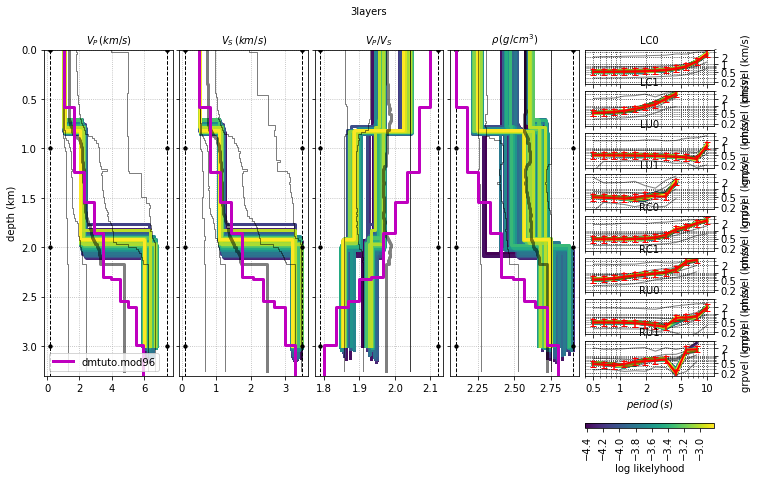

plot : best, limit 200, llkmin 0.000000, step 1 retrieved 200 models in 1.010497s 
pdf : last, limit 0, llkmin 0.000000, step 1 retrieved 3210 models in 1.917862s 
Stacker Worker-0004 stacked    409 jobs in 0.309834s
Stacker Worker-0008 stacked    348 jobs in 0.253149s
Stacker Worker-0003 stacked    402 jobs in 0.311846s
Stacker Worker-0007 stacked    360 jobs in 0.254551s
Stacker Worker-0001 stacked    442 jobs in 0.326315s
Stacker Worker-0002 stacked    441 jobs in 0.347277s
Stacker Worker-0005 stacked    411 jobs in 0.313690s
Stacker Worker-0006 stacked    397 jobs in 0.308501s


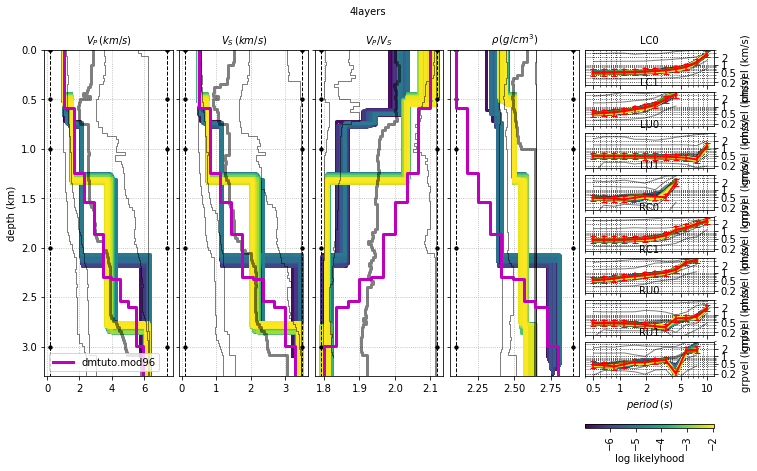

In [3]:
# -----------------
# display results
# -----------------
# %run -i ../../srfpython/bin/HerrMet -help display
%run -i ../../srfpython/bin/HerrMet \
    -verbose 0 \
    --display _HerrMet_2layers _HerrMet_3layers _HerrMet_4layers \
        -plot best 200 0. 1 \
        -cmap viridis \
        -pdf  \
        -m96 dmtuto.mod96 \
        -inline

In [ ]:
#clean up
os.system('rm -rf *surf96 *mod96 _HerrMet*')

In [ ]:
ls ./*